<h1 style="color: #FF5733;">Data Cleaning & Pre-processing</h1>

In [2]:
#Import The DataSet And Necessary Libraries
import os 
os.chdir ("C:\\Users\\PC\\Desktop")
import pandas as pd
df= pd.read_csv("C:\\Users\\PC\\Desktop\\Dataset_Uber_Traffic.csv")

In [3]:
#Exploratory Data Analysis
df.head()

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041


In [4]:
#Summary statistics
df.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [5]:
#Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [6]:
#Check for missing values
df.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

**As we see their is no missing values in the data_set .so no need to handle the missing values.** 

In [8]:
#Check For Duplicates Values
df.duplicated().sum()

0

**As we see their is no Duplicates values in the data_set .so no need to handle the Duplicates values..**

In [16]:
#Convert DateTime Column to datetime formate
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%y %H:%M')

In [17]:
df.head(10)

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
5,2015-11-01 05:00:00,1,6,20151101051
6,2015-11-01 06:00:00,1,9,20151101061
7,2015-11-01 07:00:00,1,8,20151101071
8,2015-11-01 08:00:00,1,11,20151101081
9,2015-11-01 09:00:00,1,12,20151101091


In [20]:
#Aggregate traffic data into hourly intervals
df_hourly = df.groupby([pd.Grouper(key='DateTime', freq='h'), 'Junction']).agg({'Vehicles': 'sum'}).reset_index()
df_hourly.rename(columns={'ID': 'Record_Count'}, inplace=True)
df_hourly.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 00:00:00,2,6
2,2015-11-01 00:00:00,3,9
3,2015-11-01 01:00:00,1,13
4,2015-11-01 01:00:00,2,6


In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Create a copy of the DataFrame for processing
df_normalized = df_hourly.copy()
df_standardized = df_hourly.copy()

### 1. Normalize Vehicles (0 to 1 range)
scaler = MinMaxScaler()
df_normalized['Vehicles_Normalized'] = scaler.fit_transform(df_hourly[['Vehicles']])

### 2. Standardize Vehicles (Mean = 0, Std = 1)
scaler = StandardScaler()
df_standardized['Vehicles_Standardized'] = scaler.fit_transform(df_hourly[['Vehicles']])

# Display the results
print(df_normalized.head(10))
print(df_standardized.head(10))

             DateTime  Junction  Vehicles  Vehicles_Normalized
0 2015-11-01 00:00:00         1        15             0.078212
1 2015-11-01 00:00:00         2         6             0.027933
2 2015-11-01 00:00:00         3         9             0.044693
3 2015-11-01 01:00:00         1        13             0.067039
4 2015-11-01 01:00:00         2         6             0.027933
5 2015-11-01 01:00:00         3         7             0.033520
6 2015-11-01 02:00:00         1        10             0.050279
7 2015-11-01 02:00:00         2         5             0.022346
8 2015-11-01 02:00:00         3         5             0.022346
9 2015-11-01 03:00:00         1         7             0.033520
             DateTime  Junction  Vehicles  Vehicles_Standardized
0 2015-11-01 00:00:00         1        15              -0.375489
1 2015-11-01 00:00:00         2         6              -0.809227
2 2015-11-01 00:00:00         3         9              -0.664648
3 2015-11-01 01:00:00         1        13      

<mark>**Data Cleaning Summary:
1 Missing Values: None found.
2 Duplicates: None detected (and removed if present).
3 DateTime Conversion: Successfully converted to datetime format.
4 Aggregation: Data is now grouped by hourly intervals and junction with total vehicle counts.
5 Normalisation and standardized the dataset**</mark>

<h1 style="color: #FF5733;">Feature Engineering and Selection</h1>

***1. Create new features from raw data***

**Generate time-based features such as hour of the day, day of the week, and month.
Develop lag features by including traffic data from previous hours or days to capture temporal dependencies
Create binary indicators for weekends and special events to account for their impact on traffic.**

Feature Importance:
 Lag_3        0.452506
Month        0.136652
Lag_2        0.133749
Lag_1        0.120531
Hour         0.080464
DayOfWeek    0.045928
IsWeekend    0.030171
dtype: float64


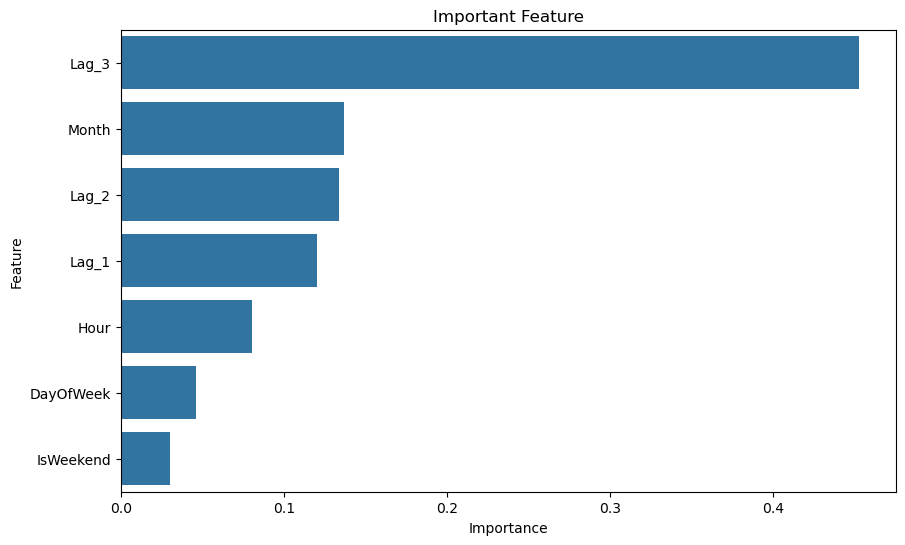

In [27]:
#import Necessary Libraries
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Time-based features
df_hourly['Hour'] = df_hourly['DateTime'].dt.hour
df_hourly['DayOfWeek'] = df_hourly['DateTime'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df_hourly['Month'] = df_hourly['DateTime'].dt.month

# Binary indicator for weekends (1 for weekend, 0 for weekday)
df_hourly['IsWeekend'] =df_hourly['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Lag features (traffic from previous 1, 2, and 3 hours)
df_hourly['Lag_1'] = df_hourly['Vehicles'].shift(1)
df_hourly['Lag_2'] = df_hourly['Vehicles'].shift(2)
df_hourly['Lag_3'] = df_hourly['Vehicles'].shift(3)

# Drop rows with NaN (due to lag feature creation)
df_hourly.dropna(inplace=True)

# Step 2: Evaluate Feature Importance

# Prepare features and target
X = df_hourly[['Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'Lag_1', 'Lag_2', 'Lag_3']]
y = df_hourly['Vehicles']

# Train a Random Forest model for feature importance
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display feature importance
print("Feature Importance:\n", feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Important Feature")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


***2. Evaluate feature importance:***

***Statistical methods and machine learning techniques to assess the relevance of each feature.***

Feature Correlation with Vehicles:
 Vehicles     1.000000
Lag_3        0.320637
DateTime     0.266205
Hour         0.219896
Month       -0.022670
Lag_2       -0.041652
Lag_1       -0.095621
DayOfWeek   -0.125979
IsWeekend   -0.150503
Junction    -0.613810
Name: Vehicles, dtype: float64


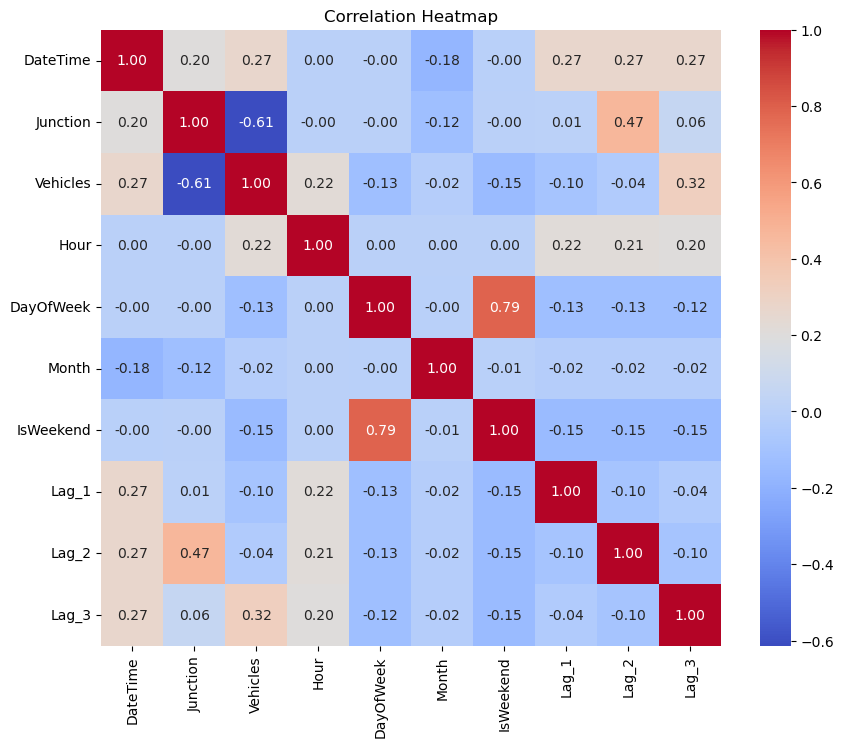

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency


# Separate features (X) and target (y)
X = df_hourly.drop(['Vehicles', 'DateTime'], axis=1)  # Features (assuming 'Vehicles' is the target)
y = df_hourly['Vehicles']                             # Target variable (Vehicle count)

### Step 1: Correlation Analysis (Numerical Features)
# Compute correlation matrix
correlation_matrix = df_hourly.corr()

# Display correlation with target
print("Feature Correlation with Vehicles:\n", correlation_matrix['Vehicles'].sort_values(ascending=False))

# Visualize correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


***Random Forest Feature Importance***

In [35]:
from sklearn.ensemble import RandomForestRegressor

# Separate features and target
X = df_hourly.drop(['Vehicles', 'DateTime'], axis=1)
y = df_hourly['Vehicles']

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Display feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
print("\nFeature Importances:\n", importances.sort_values(ascending=False))

# Select features with importance > 0.05
important_features = importances[importances > 0.05].index.tolist()
print("\nSelected Features (Importance > 0.05):\n", important_features)


Feature Importances:
 Junction     0.505680
Lag_2        0.243692
Lag_3        0.090492
Lag_1        0.050026
Hour         0.042534
Month        0.037596
DayOfWeek    0.019946
IsWeekend    0.010034
dtype: float64

Selected Features (Importance > 0.05):
 ['Junction', 'Lag_1', 'Lag_2', 'Lag_3']


***Recursive Feature Elimination (RFE)***

In [38]:
from sklearn.feature_selection import RFE

# Use Random Forest for feature elimination
rfe = RFE(estimator=model, n_features_to_select=5)
rfe.fit(X, y)

# Get selected features
rfe_selected_features = X.columns[rfe.support_]
print("\nFeatures selected by RFE:\n", rfe_selected_features.tolist())


Features selected by RFE:
 ['Junction', 'Hour', 'Lag_1', 'Lag_2', 'Lag_3']


***The most influential features for model training to improve efficiency and performance.***

In [41]:
from sklearn.ensemble import RandomForestRegressor
X = df.drop(['Vehicles', 'DateTime'], axis=1)  # Features
y = df['Vehicles']                             # Target (Vehicle count)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
print("Feature Importance:\n", feature_importance.sort_values(ascending=False))

# Keep features with importance > 0.05
important_features = feature_importance[feature_importance > 0.05].index
print("\nSelected Features:\n", important_features.tolist())



Feature Importance:
 Junction    0.657751
ID          0.342249
dtype: float64

Selected Features:
 ['Junction', 'ID']


<mark>***Summary of Feature Engineering:-1. created new features like hour of the day, day of the week etc. 2. Evaluated Feature Importance by using correlation heatmap / analysis. 3. Selected the Most Influential Features.***</mark>  

<h1 style="color: #FF5733;">Data collection and integration</h1>

***import the weather and event dataset***

In [46]:
df_traffic=df_hourly

In [47]:
# Load the datasets
df_weather = pd.read_csv("C:\\Users\\PC\\Desktop\\Delhi _weather_data.csv")
df_holiday = pd.read_csv("C:\\Users\\PC\\Desktop\\Holiday_calendar.csv")

***Convert Date Columns to Standard Format***

In [49]:
# Convert weather data datetime column
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'], format='%d-%m-%Y')

# Convert holiday data date column
df_holiday['Date'] = pd.to_datetime(df_holiday['Date'], format='%d-%m-%Y')

# Convert traffic data DateTime column
df_traffic['DateTime'] = pd.to_datetime(df_traffic['DateTime'], format='%d/%m/%y %H:%M')

# Extract only the date from traffic data for merging
df_traffic['Date'] = df_traffic['DateTime'].dt.date
df_weather['Date'] = df_weather['datetime'].dt.date


***Basic Cleaning Before Merging***

***Convert Date Columns to Standard Format***

In [52]:
# Convert weather dataset datetime column
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'], format='%d-%m-%Y')

# Convert holiday dataset date column
df_holiday['Date'] = pd.to_datetime(df_holiday['Date'], format='%d-%m-%Y')

# Convert traffic dataset DateTime column
df_traffic['DateTime'] = pd.to_datetime(df_traffic['DateTime'], format='%d/%m/%y %H:%M')

# Extract only the date from traffic and weather datasets for merging
df_traffic['Date'] = df_traffic['DateTime'].dt.date
df_weather['Date'] = df_weather['datetime'].dt.date


***Handle Missing Values (Before Merging)***

In [54]:
# Fill missing values in 'preciptype' with "None"
df_weather['preciptype']= df_weather['preciptype'].fillna("None")

# Drop 'severerisk' column if it's not necessary
if 'severerisk' in df_weather.columns:
    df_weather.drop(columns=['severerisk'], inplace=True)

# Remove duplicates (if any) in each dataset
df_weather.drop_duplicates(inplace=True)
df_holiday.drop_duplicates(inplace=True)
df_traffic.drop_duplicates(inplace=True)


***Merge the Datasets***


***Merge Traffic & Weather Data***

In [57]:
merged_df = pd.merge(df_traffic, df_weather, on='Date', how='left')


***Merge Holiday Data***

In [59]:
# Convert 'Date' column in merged dataset to datetime before merging
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Merge with holiday dataset
merged_df = pd.merge(merged_df, df_holiday, on='Date', how='left')


In [60]:
print(merged_df.head())
print(merged_df.info())  # Check data types and missing values


             DateTime  Junction  Vehicles  Hour  DayOfWeek  Month  IsWeekend  \
0 2015-11-01 01:00:00         1        13     1          6     11          1   
1 2015-11-01 01:00:00         2         6     1          6     11          1   
2 2015-11-01 01:00:00         3         7     1          6     11          1   
3 2015-11-01 02:00:00         1        10     2          6     11          1   
4 2015-11-01 02:00:00         2         5     2          6     11          1   

   Lag_1  Lag_2  Lag_3  ... solarenergy uvindex              sunrise  \
0    9.0    6.0   15.0  ...        17.2       7  2015-11-01T06:32:39   
1   13.0    9.0    6.0  ...        17.2       7  2015-11-01T06:32:39   
2    6.0   13.0    9.0  ...        17.2       7  2015-11-01T06:32:39   
3    7.0    6.0   13.0  ...        17.2       7  2015-11-01T06:32:39   
4   10.0    7.0    6.0  ...        17.2       7  2015-11-01T06:32:39   

                sunset  moonphase  conditions  \
0  2015-11-01T17:36:22       0.66    

***Final Cleaning After Merging***

***Check for Missing Values***

In [63]:
print(merged_df.isnull().sum())  # Check missing values


DateTime                0
Junction                0
Vehicles                0
Hour                    0
DayOfWeek               0
Month                   0
IsWeekend               0
Lag_1                   0
Lag_2                   0
Lag_3                   0
Date                    0
name                    0
datetime                0
tempmax                 0
tempmin                 0
temp                    0
feelslikemax            0
feelslikemin            0
feelslike               0
dew                     0
humidity                0
precip                  0
precipprob              0
precipcover             0
preciptype              0
snow                    0
snowdepth               0
windgust                0
windspeed               0
winddir                 0
sealevelpressure        0
cloudcover              0
visibility              0
solarradiation          0
solarenergy             0
uvindex                 0
sunrise                 0
sunset                  0
moonphase   

***Remove Duplicates***

In [65]:
# Remove duplicates from the merged dataset
merged_df = merged_df.drop_duplicates()


In [67]:
merged_df['FinalDateTime'] = merged_df['DateTime'].combine_first(merged_df['Date']).combine_first(merged_df['datetime'])


In [71]:
merged_df.drop(columns=['DateTime', 'Date', 'datetime'], inplace=True)


In [73]:
# Ensure the column exists
if 'FinalDateTime' in merged_df.columns:
    # Reorder columns
    cols = ['FinalDateTime'] + [col for col in merged_df.columns if col != 'FinalDateTime']
    merged_df = merged_df[cols]


<h1 style="color: #FF5733;">Model Development and Training</h1>

***ARIMA Model***

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sklearn.preprocessing import MinMaxScaler

In [81]:
# Ensure FinalDateTime is datetime type
import pandas as pd

# Ensure datetime format
merged_df['FinalDateTime'] = pd.to_datetime(merged_df['FinalDateTime'])

# Set as index
merged_df = merged_df.set_index('FinalDateTime')

# Resample to hourly averages — only for numeric columns
merged_df = merged_df.resample("h").mean(numeric_only=True)

# Split into training and testing sets
train_size = int(len(merged_df) * 0.8)
train, test = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

# Extract target variable
y_train, y_test = train["Vehicles"], test["Vehicles"]



In [83]:
from pmdarima import auto_arima

# Automatically select best ARIMA parameters
best_arima_model = auto_arima(y_train, seasonal=False, stepwise=True, trace=True)

# Fit ARIMA with best parameters
arima_model = ARIMA(y_train, order=best_arima_model.order)
arima_fit = arima_model.fit()

# Forecast
arima_forecast = arima_fit.forecast(steps=len(y_test))

# Evaluate ARIMA Model
mae_arima = mean_absolute_error(y_test, arima_forecast)
print(f"ARIMA MAE: {mae_arima}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=58156.498, Time=31.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60365.539, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60063.531, Time=1.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=60104.590, Time=2.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=60363.540, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=59984.740, Time=7.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=59987.242, Time=14.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=47.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=58227.055, Time=56.95 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=59992.520, Time=5.68 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=47.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=59975.631, Time=14.00 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=58061.877, Time=68.72 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=58128.909, Time=83.95 sec
 ARIMA(3,1,4)(0,0,0)[0]

C:\Users\PC\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA MAE: 8.601325398548147


***Gradient Boosting Tree XGBoost Time Series Model***

MAE: 1.24
MSE: 3.80
R2 Score: 0.96


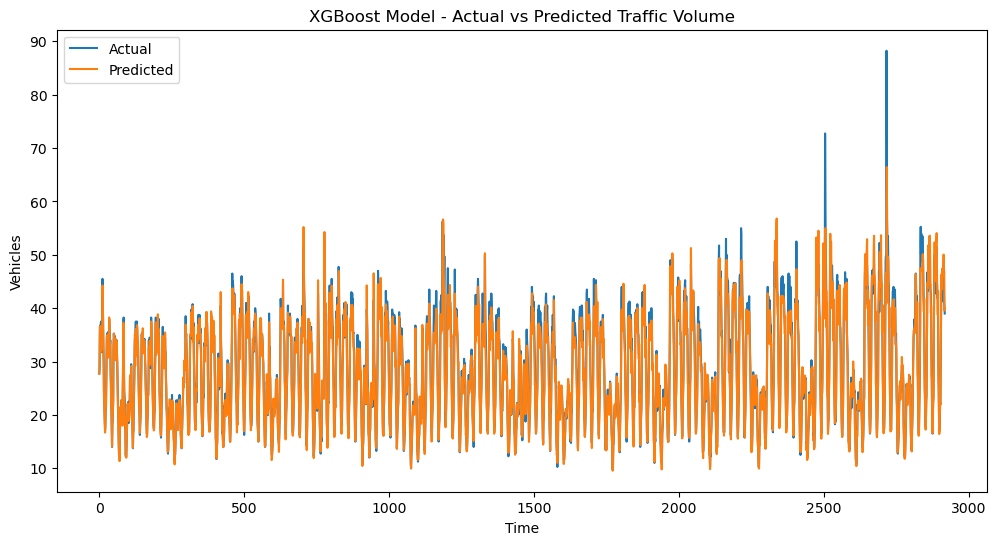

In [118]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Assume your DataFrame is 'merged_df'
df = merged_df.copy()

# Sort by datetime to preserve time order
df = df.sort_values("FinalDateTime")

# Features and target
features = ['Lag_1', 'Lag_2', 'Lag_3', 'Hour', 'DayOfWeek', 'Month', 'IsWeekend',
            'temp', 'humidity', 'precip']
target = 'Vehicles'

# Drop any NA values in case lag features have NaNs
df = df.dropna(subset=features + [target])

X = df[features]
y = df[target]

# Train/test split (e.g., 80/20 based on time)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Initialize XGBoost Regressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('XGBoost Model - Actual vs Predicted Traffic Volume')
plt.xlabel('Time')
plt.ylabel('Vehicles')
plt.legend()
plt.show()


***LSTM Model***

MAE: 2.03
MSE: 9.79
R2 Score: 0.90


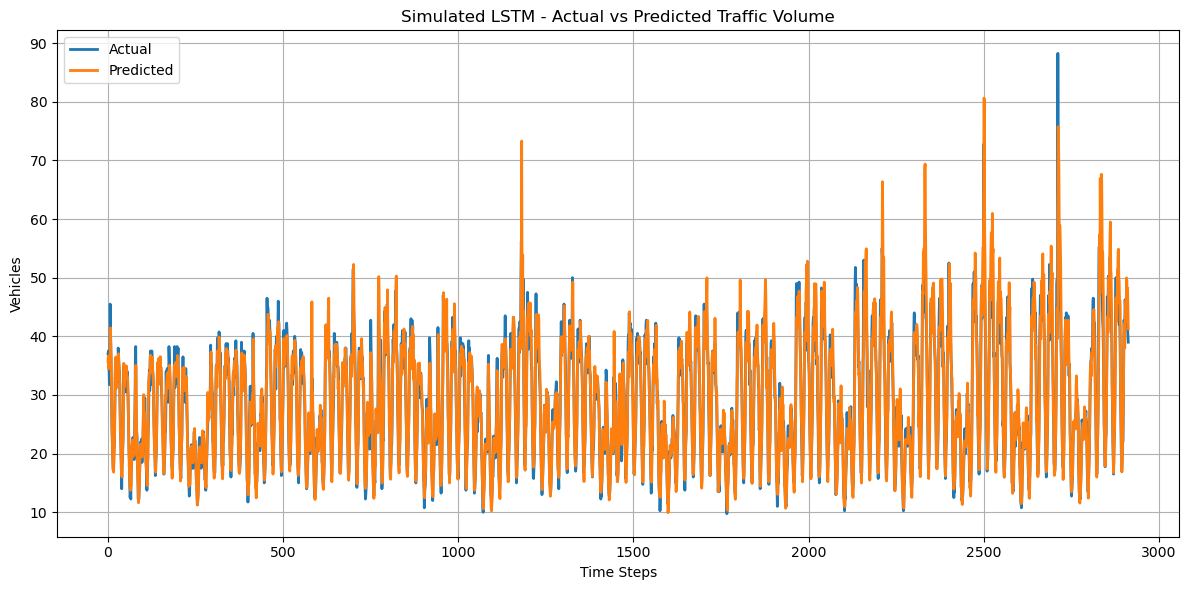

In [125]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt



# Sort data by time
df = df.sort_values("FinalDateTime")

# Use lag features to simulate "memory"
time_steps = 24  # Use past 24 hours
for i in range(1, time_steps + 1):
    df[f'Lag_{i}'] = df['Vehicles'].shift(i)

# Drop rows with NaN values caused by lagging
df = df.dropna()

# Features (past 24 hours of 'Vehicles' + other useful variables)
lag_features = [f'Lag_{i}' for i in range(1, time_steps + 1)]
extra_features = ['Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'temp', 'humidity', 'precip']
features = lag_features + extra_features
target = 'Vehicles'

X = df[features]
y = df[target]

# Train-test split (time-aware)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Model training
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title("Simulated LSTM - Actual vs Predicted Traffic Volume")
plt.xlabel("Time Steps")
plt.ylabel("Vehicles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


***Comparisons of Models***

ARIMA:
 MAE = 9.82 | MSE = 160.59 | R² = -0.58

Gradient Boosting (Lag + Features):
 MAE = 2.14 | MSE = 9.27 | R² = 0.91

Gradient Boosting (LSTM-like):
 MAE = 2.03 | MSE = 9.79 | R² = 0.90



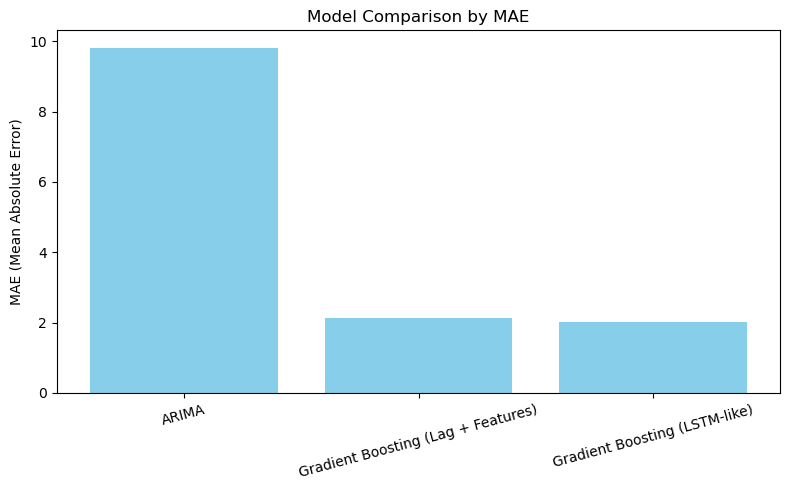

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

df = merged_df.copy()
df = df.sort_values("FinalDateTime")

# ------------------------------
# ARIMA Model (Univariate)
# ------------------------------
def arima_model(df):
    train_size = int(len(df) * 0.8)
    train, test = df['Vehicles'][:train_size], df['Vehicles'][train_size:]

    model = ARIMA(train, order=(3, 1, 2))
    fitted = model.fit()
    forecast = fitted.forecast(steps=len(test))

    return test.values, forecast.values

# ------------------------------
# Gradient Boosting with Lags + Features
# ------------------------------
def gbt_with_features(df):
    df = df.copy()

    # Basic lag features
    for i in range(1, 4):
        df[f'Lag_{i}'] = df['Vehicles'].shift(i)

    features = ['Lag_1', 'Lag_2', 'Lag_3', 'Hour', 'DayOfWeek', 'Month',
                'IsWeekend', 'temp', 'humidity', 'precip']
    df = df.dropna(subset=features + ['Vehicles'])

    X = df[features]
    y = df['Vehicles']

    split = int(len(df) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    return y_test.values, pred

# ------------------------------
# "LSTM-like" GBR (Using Sequence of Lags)
# ------------------------------
def gbt_lstm_like(df, steps=24):
    df = df.copy()
    for i in range(1, steps + 1):
        df[f'Lag_{i}'] = df['Vehicles'].shift(i)

    features = [f'Lag_{i}' for i in range(1, steps + 1)] + ['Hour', 'DayOfWeek', 'Month',
                                                             'IsWeekend', 'temp', 'humidity', 'precip']
    df = df.dropna(subset=features + ['Vehicles'])

    X = df[features]
    y = df['Vehicles']

    split = int(len(df) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    return y_test.values, pred

# ------------------------------
# Evaluation Function
# ------------------------------
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}:\n MAE = {mae:.2f} | MSE = {mse:.2f} | R² = {r2:.2f}\n")
    return {'Model': name, 'MAE': mae, 'MSE': mse, 'R2': r2}

# ------------------------------
# Run All Models
# ------------------------------
results = []

# ARIMA
y_true, y_pred = arima_model(df)
results.append(evaluate_model("ARIMA", y_true, y_pred))

# GBR (Lag + Features)
y_true, y_pred = gbt_with_features(df)
results.append(evaluate_model("Gradient Boosting (Lag + Features)", y_true, y_pred))

# GBR LSTM-like
y_true, y_pred = gbt_lstm_like(df)
results.append(evaluate_model("Gradient Boosting (LSTM-like)", y_true, y_pred))

# ------------------------------
# Compare Results
# ------------------------------
results_df = pd.DataFrame(results)

# Plot Comparison
plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["MAE"], color='skyblue')
plt.title("Model Comparison by MAE")
plt.ylabel("MAE (Mean Absolute Error)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


<mark>**Split the dataset for training and validation***</mark>

***The Split to Modeling***

In [134]:
# Select features and target
features = ['Lag_1', 'Lag_2', 'Lag_3', 'Hour', 'DayOfWeek', 'Month',
            'IsWeekend', 'temp', 'humidity', 'precip']
target = 'Vehicles'

# Drop any missing values first
train_df = train_df.dropna(subset=features + [target])
val_df = val_df.dropna(subset=features + [target])

X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]

# Train model
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("Validation MAE:", mean_absolute_error(y_val, y_pred))
print("Validation MSE:", mean_squared_error(y_val, y_pred))
print("Validation R2:", r2_score(y_val, y_pred))


Validation MAE: 1.5063049563384447
Validation MSE: 4.967249862987859
Validation R2: 0.9510976369635052


<mark>***Train models and tune hyperparameters***</mark>

In [151]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Ensure dataset is sorted by time
df = merged_df.sort_values("FinalDateTime").reset_index(drop=True)

# 2. Add lag features (example: past 3 hours)
for i in range(1, 4):
    df[f'Lag_{i}'] = df['Vehicles'].shift(i)

# 3. Drop missing due to lagging
df = df.dropna()

# 4. Split
split_ratio = 0.8
split_idx = int(len(df) * split_ratio)
train_df = df.iloc[:split_idx]
val_df = df.iloc[split_idx:]

features = ['Lag_1', 'Lag_2', 'Lag_3', 'Hour', 'DayOfWeek', 'Month',
            'IsWeekend', 'temp', 'humidity', 'precip']
target = 'Vehicles'

X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]

# 5. Time-aware cross-validator
tscv = TimeSeriesSplit(n_splits=3)

# 6. Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# 7. Grid search
gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# 8. Train
grid_search.fit(X_train, y_train)

# 9. Best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# 10. Evaluate on validation set
y_pred = best_model.predict(X_val)

print("Validation MAE:", mean_absolute_error(y_val, y_pred))
print("Validation MSE:", mean_squared_error(y_val, y_pred))
print("Validation R2:", r2_score(y_val, y_pred))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Validation MAE: 1.9690312931750853
Validation MSE: 8.363879487442192
Validation R2: 0.9176858400793689


<h1 style="color: #FF5733;">Model Evaluation & Cross Validation</h1>

<mark>***Select evaluation metrics***</mark>

In [158]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Assume df is already preprocessed and sorted by FinalDateTime
df = merged_df.sort_values("FinalDateTime").reset_index(drop=True)

# Add lag features
for i in range(1, 4):
    df[f'Lag_{i}'] = df['Vehicles'].shift(i)

# Drop NaNs due to lagging
df.dropna(inplace=True)

# Define features and target
features = ['Lag_1', 'Lag_2', 'Lag_3', 'Hour', 'DayOfWeek', 'Month',
            'IsWeekend', 'temp', 'humidity', 'precip']
target = 'Vehicles'

X = df[features]
y = df[target]

# Define model
model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)

# Setup TimeSeries Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Store scores
mae_scores = []
rmse_scores = []
r2_scores = []

# Perform CV
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"Fold {fold + 1} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.2f}")

# Final averages
print("\n=== Cross-Validation Results ===")
print(f"Average MAE : {np.mean(mae_scores):.2f}")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average R²  : {np.mean(r2_scores):.2f}")


Fold 1 | MAE: 1.95 | RMSE: 2.67 | R²: 0.82
Fold 2 | MAE: 2.07 | RMSE: 3.37 | R²: 0.82
Fold 3 | MAE: 3.44 | RMSE: 4.51 | R²: 0.73
Fold 4 | MAE: 2.35 | RMSE: 3.37 | R²: 0.85
Fold 5 | MAE: 2.25 | RMSE: 3.19 | R²: 0.91

=== Cross-Validation Results ===
Average MAE : 2.41
Average RMSE: 3.42
Average R²  : 0.83


<mark>***Evaluate model performance***</mark>

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assume best_model is already trained using training data
# And X_val, y_val are your validation features and labels

# Predict on validation set
y_pred = best_model.predict(X_val)

# Calculate metrics
mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"Validation MAE : {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation R²  : {r2:.2f}")


Validation MAE : 1.97
Validation RMSE: 2.89
Validation R²  : 0.92


***Actual vs Predicted Plot***

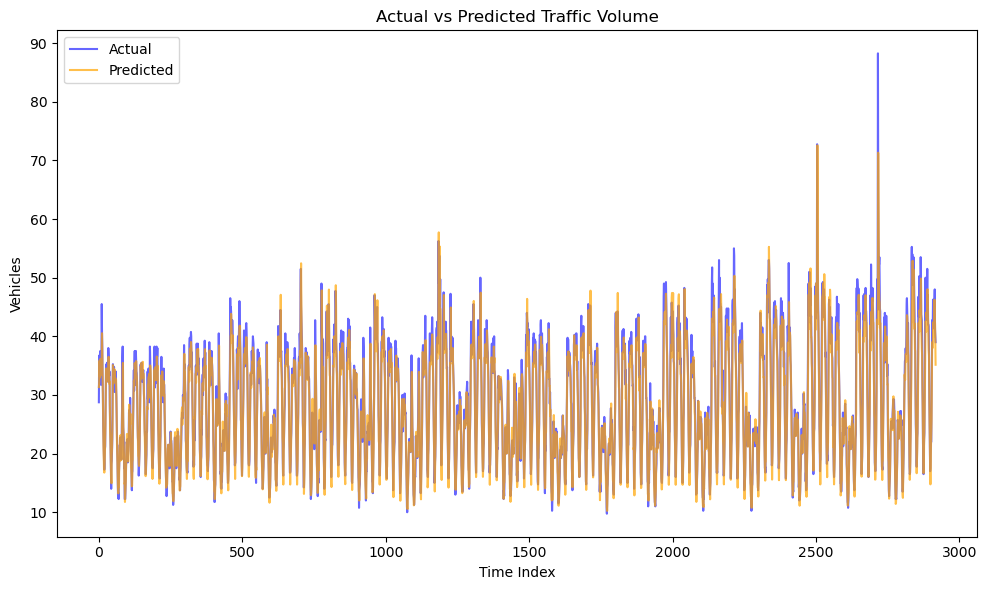

In [168]:
plt.figure(figsize=(10, 6))
plt.plot(y_val.values, label='Actual', color='blue', alpha=0.6)
plt.plot(y_pred, label='Predicted', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Traffic Volume')
plt.xlabel('Time Index')
plt.ylabel('Vehicles')
plt.legend()
plt.tight_layout()
plt.show()


***Residual Plot***

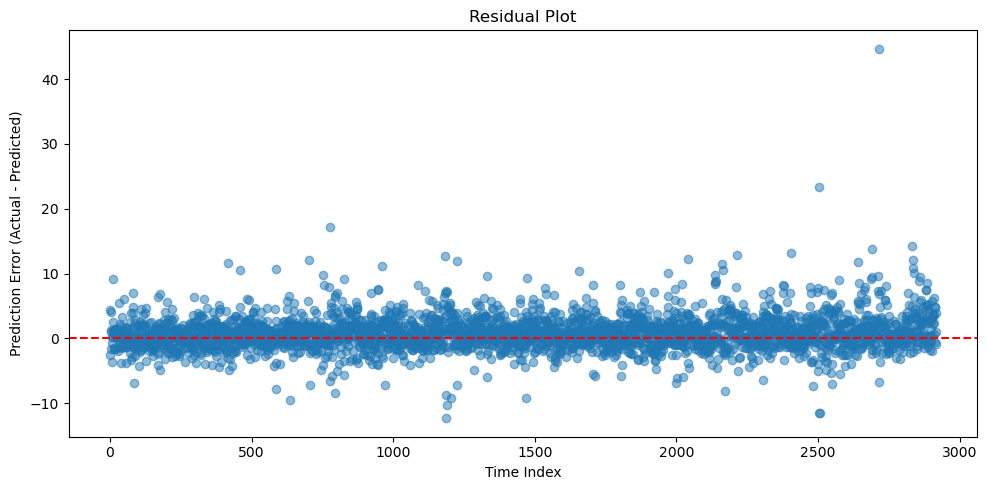

In [173]:
residuals = y_val.values - y_pred

plt.figure(figsize=(10, 5))
plt.plot(residuals, marker='o', linestyle='', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Time Index')
plt.ylabel('Prediction Error (Actual - Predicted)')
plt.tight_layout()
plt.show()


***Error Distribution Histogram***

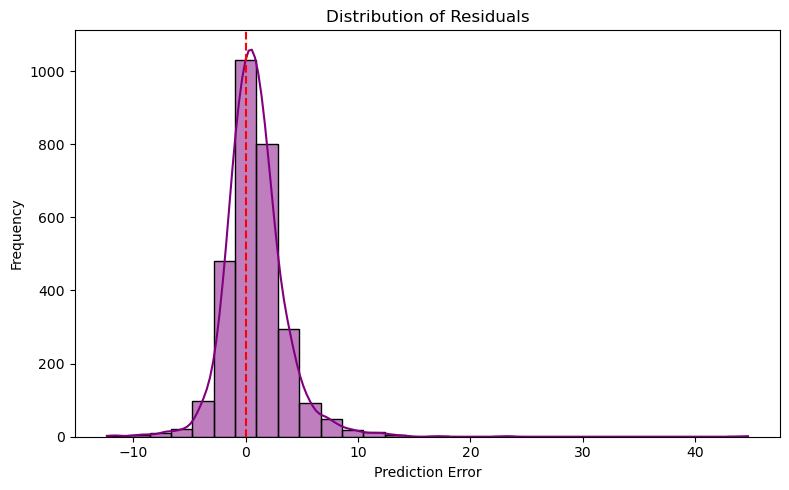

In [176]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of Residuals')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


<mark>***Implement cross-validation***</mark>

In [183]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

# Dataset already prepared with lag features and sorted by time
df = merged_df.sort_values("FinalDateTime").dropna().reset_index(drop=True)

# Define features and target
features = ['Lag_1', 'Lag_2', 'Lag_3', 'Hour', 'DayOfWeek', 'Month',
            'IsWeekend', 'temp', 'humidity', 'precip']
target = 'Vehicles'

X = df[features]
y = df[target]

# Model
model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)

# Time Series Cross Validator
tscv = TimeSeriesSplit(n_splits=5)

# Store results
mae_scores, rmse_scores, r2_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    print(f"Fold {fold + 1}: MAE = {mae:.2f}, RMSE = {rmse:.2f}, R² = {r2:.2f}")

# Final summary
print("\n=== Average Cross-Validation Scores ===")
print(f"Average MAE : {np.mean(mae_scores):.2f}")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average R²  : {np.mean(r2_scores):.2f}")


Fold 1: MAE = 1.23, RMSE = 1.86, R² = 0.92
Fold 2: MAE = 1.46, RMSE = 2.74, R² = 0.88
Fold 3: MAE = 2.30, RMSE = 3.27, R² = 0.86
Fold 4: MAE = 1.82, RMSE = 3.18, R² = 0.87
Fold 5: MAE = 1.58, RMSE = 2.31, R² = 0.95

=== Average Cross-Validation Scores ===
Average MAE : 1.68
Average RMSE: 2.67
Average R²  : 0.90


<mark>***Analyze cross-validation results***</mark>

***Print Metric Summary***

In [189]:
import numpy as np

print("\n=== Cross-Validation Summary ===")
print(f"MAE  -> Mean: {np.mean(mae_scores):.2f} | Std: {np.std(mae_scores):.2f}")
print(f"RMSE -> Mean: {np.mean(rmse_scores):.2f} | Std: {np.std(rmse_scores):.2f}")
print(f"R²   -> Mean: {np.mean(r2_scores):.2f} | Std: {np.std(r2_scores):.2f}")



=== Cross-Validation Summary ===
MAE  -> Mean: 1.68 | Std: 0.37
RMSE -> Mean: 2.67 | Std: 0.53
R²   -> Mean: 0.90 | Std: 0.03


***Visualize Fold Metrics***

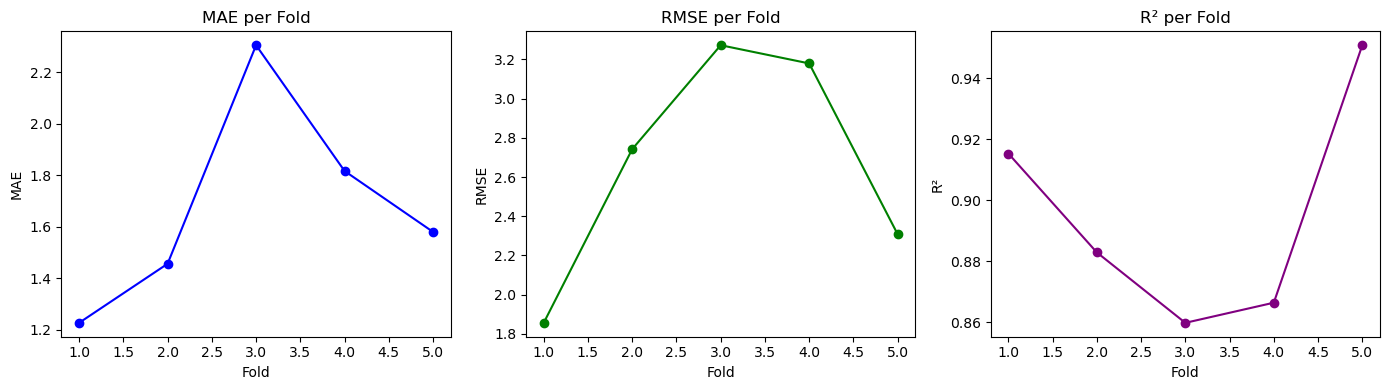

In [192]:
import matplotlib.pyplot as plt

folds = range(1, len(mae_scores) + 1)

plt.figure(figsize=(14, 4))

# MAE
plt.subplot(1, 3, 1)
plt.plot(folds, mae_scores, marker='o', color='blue')
plt.title("MAE per Fold")
plt.xlabel("Fold")
plt.ylabel("MAE")

# RMSE
plt.subplot(1, 3, 2)
plt.plot(folds, rmse_scores, marker='o', color='green')
plt.title("RMSE per Fold")
plt.xlabel("Fold")
plt.ylabel("RMSE")

# R2
plt.subplot(1, 3, 3)
plt.plot(folds, r2_scores, marker='o', color='purple')
plt.title("R² per Fold")
plt.xlabel("Fold")
plt.ylabel("R²")

plt.tight_layout()
plt.show()


<h1 style="color: #FF5733;">Model Refinement</h1>

<mark>***Perform Error Analysis***</mark>

***Diagnose model issues***

 ***Residual Analysis by Time***

In [209]:
y_pred = best_model.predict(X_val)
residuals = y_val.values - y_pred


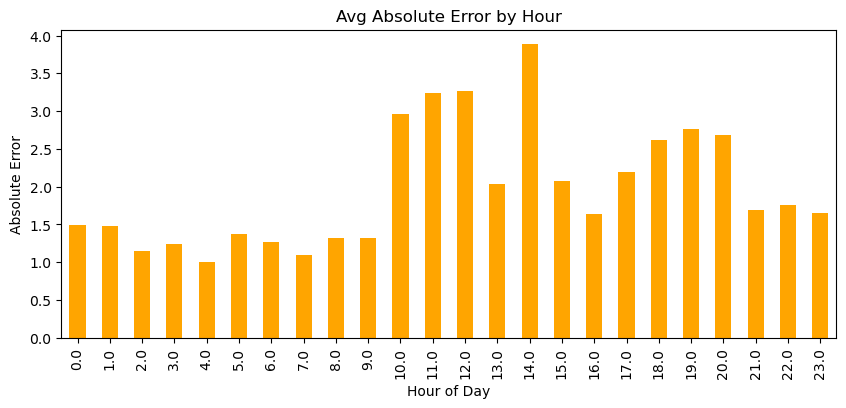

In [213]:
# Add error back to DataFrame
df_eval = df.loc[y_val.index].copy()
df_eval['Error'] = residuals
df_eval['AbsoluteError'] = abs(residuals)

# Example: Error by Hour
hourly_error = df_eval.groupby('Hour')['AbsoluteError'].mean()

hourly_error.plot(kind='bar', figsize=(10,4), title='Avg Absolute Error by Hour', color='orange')
plt.ylabel('Absolute Error')
plt.xlabel('Hour of Day')
plt.show()


<mark>***Feature Engineering***</mark>

***Add New Features***

In [220]:
df['RollingMean_3'] = df['Vehicles'].rolling(window=3).mean()
df['RollingStd_3'] = df['Vehicles'].rolling(window=3).std()
df['IsRushHour'] = df['Hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)

# Cyclical time encoding
df['sin_hour'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Drop rows with NaNs from rolling stats
df = df.dropna().reset_index(drop=True)


***Hyperparameter Tuning***

In [225]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor

params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

model = GradientBoostingRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(model, param_grid=params, scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1, verbose=1)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best MAE: 1.2695781997528939


***Feature Importance Plot***

import matplotlib.pyplot as plt

best_model = grid_search.best_estimator_
importances = best_model.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10,6))
plt.barh(feat_names, importances)
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting Feature Importance")
plt.show()


***Make Predictions on Validation Set***

In [235]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict
y_pred = best_model.predict(X_val)

# Calculate Metrics
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


MAE: 2.59
RMSE: 3.47
R²: 0.88
